In [1]:
pip uninstall -y emagin-forecast emagin-dataprep emagin-evaluation

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install emagin-dataprep emagin-forecast emagin-evaluation

Looking in indexes: https://pypi.org/simple, https://:****@pkgs.dev.azure.com/innovyze/global/_packaging/app_emagin360/pypi/simple/
     |████████████████████████████████| 49 kB 1.2 MB/s eta 0:00:011
     |████████████████████████████████| 47 kB 1.3 MB/s eta 0:00:011
     |████████████████████████████████| 121 kB 6.3 MB/s eta 0:00:01
  Using cached pandas_profiling-2.11.0-py2.py3-none-any.whl (243 kB)
  Using cached convertdate-2.3.2-py3-none-any.whl (47 kB)
  Using cached korean_lunar_calendar-0.2.1-py3-none-any.whl (8.0 kB)
  Using cached hijri_converter-2.1.1-py3-none-any.whl (14 kB)
  Using cached PyMeeus-0.5.11.tar.gz (5.4 MB)
  Using cached htmlmin-0.1.12.tar.gz (19 kB)
  Using cached missingno-0.4.2-py3-none-any.whl (9.7 kB)
  Using cached phik-0.11.2.tar.gz (1.1 MB)
  Using cached visions-0.6.0-py3-none-any.whl (75 kB)
  Using cached tangled_up_in_unicode-0.0.7-py3-none-any.whl (3.1 MB)
  Using cached confuse-1.4.0-py2.py3-none-any.whl (21 kB)
  Using cached ImageHash-4.2.0-py2

In [34]:
import numpy as np
import pandas as pd
import random
import datetime
from datetime import datetime


import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split, TimeSeriesSplit, KFold
from joblib import dump
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.ndimage.interpolation import shift
import warnings; warnings.simplefilter('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# use for local evaluation/validation
import os
import matplotlib.pyplot as plt

# notebook functionality
import joblib
import pickle
import time
import boto3
from boto3.session import Session 
import json


# evaluation module
import emagin_evaluation.evaluations as emg_eval

# feature module
import emagin_dataprep.features as edpf
import emagin_dataprep.cleaner as edpc

#forecast lib
from emagin_forecast.split_methods import SplitTrain

In [3]:
from collections.abc import Iterable

def filter_columns(df_columns, prefixes = None, suffixes = None, contains = None, remove = False):
    '''
    Filters columns based on list of prefixes, suffixes or substrings to select sets of matching features
    :param df_columns: pd.DataFrame or list; names of columns to filter.  If df provided, uses df.columns 
    :param prefixes: list or str; prefixes to include or remove.  Used to identify channels or channel combinations
    :param suffixes: list or str; suffixes to include or remove.  Used to identify lags or rolls
    :param contains: list or str; substrings to include or remove.
    :param remove: bool; True = removes matching columns, False = includes only matching columns
    :return: list of columns matching criteria
    ''' 
    if prefixes is not None and not isinstance(prefixes, list):
        prefixes = [prefixes]
    if suffixes is not None and not isinstance(suffixes, list):
        suffixes = [suffixes]
    if contains is not None and not isinstance(contains, list):
        contains = [contains]
    if isinstance(df_columns, pd.DataFrame):
        col_list = list(df_columns.columns)
    elif isinstance(df_columns, Iterable):
        col_list = df_columns        
    else:
        raise ValueError('most pass dataframe or column list to filter')
    result = []
    if prefixes is not None:
        for prefix in prefixes:
            result += [c for c in col_list if c.startswith(prefix)]
    if suffixes is not None:
        for suffix in suffixes:
            result += [c for c in col_list if c.endswith(suffix)]
    if contains is not None:
        for substring in contains:
            result += [c for c in col_list if substring in c]
    if remove:
        result = [c for c in col_list if c not in result]
    return result

## Data loading  and cleaning

In [4]:
df = pd.read_csv("saur_merged_data_10march.csv")
df["DATE_TIME"] = pd.to_datetime(df["DATE_TIME"])
df = df.set_index("DATE_TIME")

In [7]:

trimmers = []

zero_threshold = ['do_bae3', 'mlss_bae2', 'polymer_flow_2', 'polymer_flow_4', 'was_1', 'was_2', 'ammonia_filters_feed', 'temp_filters_feed']

less_than_columns = {col: 0.00000001 for col in zero_threshold}
less_than_columns["influent_flow"] = 2000
less_than_columns["filter_flowrate"] = 100
less_than_columns["ammonia_filters_feed"] = 1
less_than_columns["temp_filters_feed"] = 3

for col in df.columns:
    if "tss_cla" in col:
        less_than_columns[col] = 1


for column, value in less_than_columns.items():
    if value == 0:
        value = 0.00000001
    trimmer = edpc.ThresholdTrimmer(remove="less", col=column, threshold=value)
    trimmers.append(trimmer)


greater_than_columns = {'ammonia_effluent': 20, 'tss_filters_feed': 100, 'ammonia_filters_effluent': 20, 'tss_effluent': 28, 'ammonia_filters_feed': 30
                       , 'temp_filters_feed': 20, 'ferric_flow_3': 400}
for col in df.columns:
    if "mlss_bae" in col:
        greater_than_columns[col] = 1.8
    if "tss_cla" in col:
        greater_than_columns[col] = 40

for column, value in greater_than_columns.items():
    if value == 0:
        value = 0.00000001
    trimmer = edpc.ThresholdTrimmer(remove="greater", col=column, threshold=value)
    trimmers.append(trimmer)


cleaner_pipeline = edpc.Pipeline(trimmers)

trimmed_df, _ = cleaner_pipeline.execute(df)

INFO:ThresholdTrimmer:0 entries less than 1e-08 removed from do_bae3
INFO:ThresholdTrimmer:0 entries of column: do_bae3 has been removed
INFO:ThresholdTrimmer:0 entries less than 1e-08 removed from mlss_bae2
INFO:ThresholdTrimmer:0 entries of column: mlss_bae2 has been removed
INFO:ThresholdTrimmer:16 entries greater than 1.8 removed from mlss_bae2
INFO:ThresholdTrimmer:16 entries of column: mlss_bae2 has been removed
INFO:ThresholdTrimmer:145 entries less than 1e-08 removed from polymer_flow_2
INFO:ThresholdTrimmer:145 entries of column: polymer_flow_2 has been removed
INFO:ThresholdTrimmer:62 entries less than 1e-08 removed from polymer_flow_4
INFO:ThresholdTrimmer:62 entries of column: polymer_flow_4 has been removed
INFO:ThresholdTrimmer:26 entries less than 1e-08 removed from was_1
INFO:ThresholdTrimmer:26 entries of column: was_1 has been removed
INFO:ThresholdTrimmer:55 entries less than 1e-08 removed from was_2
INFO:ThresholdTrimmer:55 entries of column: was_2 has been removed


In [8]:
trimmed_df.tail()

do_bae1   do_bae2  do_bae3  do_bae4  blower1_speed1  \
DATE_TIME                                                                  
2021-03-04 12:45:00    4.848  4.987000    5.103    7.632       27.889999   
2021-03-04 13:00:00    4.656  4.938000    5.102    7.447       32.400002   
2021-03-04 13:15:00    5.298  5.447001    4.998    7.447       31.174999   
2021-03-04 13:30:00    5.166  5.421000    5.184    7.512       27.320000   
2021-03-04 13:45:00    4.674  4.964000    4.946    7.475       29.510000   

                     blower_satanby_12  blower2_speed1  blower1_speed2  \
DATE_TIME                                                                
2021-03-04 12:45:00              0.055       27.750000       44.560001   
2021-03-04 13:00:00              0.050       32.290001       44.935001   
2021-03-04 13:15:00              0.060       31.060001       41.720001   
2021-03-04 13:30:00              0.065       27.180000       35.160000   
2021-03-04 13:45:00              0.060       29.390001       33.980000   

                     blower2_speed2  blower1_speed3  ...  Blower_2_BAE_3  \
DATE_TIME                                            ...                   
2021-03-04 12:45:00             0.0       31.079998  ...             0.0   
2021-03-04 13:00:00             0.0       31.500000  ...             0.0   
2021-03-04 13:15:00             0.0       31.584999  ...             0.0   
2021-03-04 13:30:00             0.0       30.405001  ...             0.0   
2021-03-04 13:45:00             0.0       30.485001  ...             0.0   

                     Blower_3_BAE_1_2  Blower_4_BAE_2  Blower_4_BAE_4  \
DATE_TIME                                                               
2021-03-04 12:45:00               0.0       44.560001       21.529999   
2021-03-04 13:00:00               0.0       44.935001       21.535000   
2021-03-04 13:15:00               0.0       41.720001       21.529999   
2021-03-04 13:30:00               0.0       35.160000       21.535000   
2021-03-04 13:45:00               0.0       33.980000       21.535000   

                     Blower_5_BAE_2  Blower_5_BAE_4  blowersum_1  blowersum_2  \
DATE_TIME                                                                       
2021-03-04 12:45:00             0.0             0.0    55.639999    44.560001   
2021-03-04 13:00:00             0.0             0.0    64.690002    44.935001   
2021-03-04 13:15:00             0.0             0.0    62.235001    41.720001   
2021-03-04 13:30:00             0.0             0.0    54.500000    35.160000   
2021-03-04 13:45:00             0.0             0.0    58.900002    33.980000   

                     blowersum_3  blowersum_4  
DATE_TIME                                      
2021-03-04 12:45:00    31.079998    21.529999  
2021-03-04 13:00:00    31.500000    21.535000  
2021-03-04 13:15:00    31.584999    21.529999  
2021-03-04 13:30:00    30.405001    21.535000  
2021-03-04 13:45:00    30.485001    21.535000  

[5 rows x 69 columns]

In [9]:
#features = ["mlss_bae1","mlss_bae2","mlss_bae3","mlss_bae4","tss_cla20","tss_cla30","tss_cla40","do_bae1","do_bae2","do_bae3","do_bae4","influent_flow","temperature_dalmuir"]
features = ["tss_cla20","tss_cla30","tss_cla40","do_bae1","do_bae2","do_bae3","do_bae4","influent_flow","temperature_dalmuir"]

#features = ["was_3", "influent_flow"]
targets = ["temp_filters_feed"]



In [11]:
cleaning_list=[]
cleaning_list.append(edpc.ThresholdTrimmer(col='temp_filters_feed', threshold=3,remove='less'))
cleaning_list.append(edpc.ThresholdTrimmer(col='temp_filters_feed', threshold=20,remove='greater'))
cleaning_list.append(edpc.LocalOutlierTrimmer(col='temp_filters_feed', window_size=96*2,N=3))
cleaning_list.append(edpc.Interpolator(operation='linear',col='temp_filters_feed',limit=10000))
pipeline = edpc.Pipeline(cleaning_list)

res_df, _ = pipeline.execute(df)
pipeline.create_preprocess_config()

INFO:ThresholdTrimmer:1227 entries less than 3 removed from temp_filters_feed
INFO:ThresholdTrimmer:1227 entries of column: temp_filters_feed has been removed
INFO:ThresholdTrimmer:34 entries greater than 20 removed from temp_filters_feed
INFO:ThresholdTrimmer:34 entries of column: temp_filters_feed has been removed
INFO:LocalOutlierTrimmer:1049 entries for column: temp_filters_feed removed!!!
INFO:Interpolator:2832 missing entries before interpolation
INFO:Interpolator:0 missing entries after interpolation


[{'channel_cleaning': {'temp_filters_feed': [{'func_name': 'ThresholdTrimmer',
     'threshold': 3,
     'remove': 'less'},
    {'func_name': 'ThresholdTrimmer', 'threshold': 20, 'remove': 'greater'},
    {'func_name': 'LocalOutlierTrimmer', 'window_size': 192, 'N': 3},
    {'func_name': 'Interpolator', 'operation': 'linear', 'limit': 10000}]}}]

In [13]:
df = res_df[features+targets].copy()

In [14]:
df = df[~df.index.duplicated(keep='first')]

## Feature Generation

In [17]:
rg = edpf.RollerGeneration(col_list=features).transform(dataset=df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 117 out of 117 | elapsed: 13.8min finished


In [18]:
lags_df = edpf.LagCreater(lags = range(-1, -5, -1), remove_initial_column = True, new_name = True).transform(rg)

In [19]:
results_df = pd.concat([rg, lags_df], axis = 1)


In [20]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35384 entries, 2020-03-01 00:00:00 to 2021-03-04 13:45:00
Columns: 7070 entries, tss_cla30 to temperature_dalmuir_trend4_rr100_lg-4
dtypes: float64(7070)
memory usage: 1.9 GB


## Feature Selection

In [21]:
# Review any nulls created by feature generation.
rd_nulls = results_df.isnull().sum().transpose().sort_values(ascending = False)
# rd_nulls = results_df[target + considered_features].isnull().sum().transpose().sort_values(ascending = False)

# Note that rmse_r2 nulls are expected since there is not error fitting 2 points.
rd_nulls[rd_nulls > 0].head(50)


tss_cla30_rmse_rr2_lg-1              35384
do_bae3_rmse_rr2                     35384
do_bae3_mse_rr2_lg-4                 35384
do_bae3_rmse_rr2_lg-4                35384
tss_cla30_rmse_rr2_lg-3              35384
tss_cla30_mse_rr2_lg-3               35384
tss_cla30_mse_rr2_lg-2               35384
tss_cla30_rmse_rr2_lg-2              35384
influent_flow_mse_rr2_lg-4           35384
tss_cla30_mse_rr2_lg-1               35384
do_bae1_mse_rr2_lg-2                 35384
do_bae1_rmse_rr2_lg-2                35384
do_bae1_mse_rr2_lg-4                 35384
do_bae2_rmse_rr2                     35384
tss_cla20_mse_rr2_lg-1               35384
tss_cla20_rmse_rr2_lg-1              35384
do_bae2_rmse_rr2_lg-3                35384
do_bae2_mse_rr2_lg-3                 35384
do_bae2_mse_rr2                      35384
tss_cla40_rmse_rr2_lg-4              35384
tss_cla40_mse_rr2_lg-4               35384
do_bae3_mse_rr2                      35384
influent_flow_rmse_rr2_lg-4          35384
do_bae3_rms

In [22]:
# Clean up nulls and limit to set of features based on logic.  These could also be limited in combinations above, but I am lazy and choose to do here.

# Set domain for feature search
considered_features = filter_columns(results_df, prefixes = features)
considered_features = filter_columns(considered_features, contains = ['rmse_rr2','mse_rr2'], remove = True)

# Build training set
ts = results_df[targets + considered_features].dropna()
X = ts[considered_features]
y = ts[targets[0]]
ts.shape


(32550, 6886)

In [23]:
# Define a larger set of rf hyperparameters that can handle this size of feature domain.  I am not accusomed to this domain size set so to discuss/#TBD.
fs_params = {
    "max_depth": 100,
    "max_features": 100, 
    "n_estimators": 100, 
    "min_samples_leaf": 10, 
#     "min_samples_split": 10, 
#     "max_leaf_nodes": 10, 
#     "criterion":  "gini", "entropy",
#     "min_impurity_decrease": np.geomspace(5e-5, .01, 10),
}

fs_estimator = RandomForestRegressor(n_jobs=-1, **fs_params)


In [24]:
from sklearn.feature_selection import RFE


In [25]:
selector = RFE(fs_estimator, n_features_to_select=90, step=.1, verbose = 1)
selector = selector.fit(X, y)


Fitting estimator with 6885 features.
Fitting estimator with 6197 features.
Fitting estimator with 5509 features.
Fitting estimator with 4821 features.
Fitting estimator with 4133 features.
Fitting estimator with 3445 features.
Fitting estimator with 2757 features.
Fitting estimator with 2069 features.
Fitting estimator with 1381 features.
Fitting estimator with 693 features.


In [26]:
# Review resulting features.  Note that I have used many other methods to narrow this scope to a smaller list.
# TBD Have discussion with guest speaker. Scheduled Thursday.
features = pd.DataFrame(selector.support_, columns = ['included'])
features['feature'] = X.columns
features['ranking'] = selector.ranking_
features['importance'] = None
features.loc[features.included, 'importance'] = selector.estimator_.feature_importances_
features.sort_values(['ranking', 'importance'], ascending = [True, False], inplace = True)
features[features.included]['feature']


6240          temperature_dalmuir_max_rr80
6252          temperature_dalmuir_max_rr90
6405     temperature_dalmuir_max_rr90_lg-1
6711     temperature_dalmuir_max_rr90_lg-3
6864     temperature_dalmuir_max_rr90_lg-4
                       ...                
6687     temperature_dalmuir_max_rr70_lg-3
6403    temperature_dalmuir_mean_rr90_lg-1
6556    temperature_dalmuir_mean_rr90_lg-2
6402     temperature_dalmuir_sum_rr90_lg-1
6555     temperature_dalmuir_sum_rr90_lg-2
Name: feature, Length: 100, dtype: object

In [27]:
features = list(features[features.included]['feature'])

In [28]:
#Generate feature transformation config for syspec
from emagin_dataprep.features.name_based_config_generation import TransformationConfig

In [29]:
tc = TransformationConfig(features)
config = tc.generate()


In [30]:
config


{'input_columns': ['temperature_dalmuir',
  'tss_cla40',
  'do_bae3',
  'influent_flow',
  'tss_cla30',
  'do_bae2',
  'do_bae4'],
 'output_columns': ['temperature_dalmuir_max_rr80',
  'temperature_dalmuir_max_rr90',
  'temperature_dalmuir_max_rr90_lg-1',
  'temperature_dalmuir_max_rr90_lg-3',
  'temperature_dalmuir_max_rr90_lg-4',
  'temperature_dalmuir_max_rr90_lg-2',
  'temperature_dalmuir_max_rr80_lg-1',
  'temperature_dalmuir_max_rr80_lg-2',
  'temperature_dalmuir_max_rr100',
  'temperature_dalmuir_max_rr100_lg-4',
  'tss_cla40_min_rr100_lg-4',
  'temperature_dalmuir_max_rr100_lg-1',
  'temperature_dalmuir_max_rr80_lg-3',
  'temperature_dalmuir_max_rr100_lg-3',
  'temperature_dalmuir_max_rr80_lg-4',
  'temperature_dalmuir_max_rr100_lg-2',
  'do_bae3_max_rr100',
  'influent_flow_mean_rr100',
  'tss_cla30_sum_rr100_lg-4',
  'do_bae2_max_rr60_lg-1',
  'do_bae4_max_rr100_lg-4',
  'temperature_dalmuir_sum_rr100_lg-1',
  'temperature_dalmuir_min_rr100',
  'do_bae2_min_rr100_lg-3',
  'ts

# Forecast lib training

In [31]:
SM = SplitTrain(ts, {'ts_kfold_split': {'k_folds': 4}})
SM.split()
test_params = {
            "max_depth": 100,
            "max_features": 4,
            "n_estimators": 100,
            "min_samples_leaf": 10
}

test_estimator = RandomForestRegressor(n_jobs=-1, **test_params)
cv_predictions = SM.cv_predict(features, targets[0], test_estimator)
model_results = SM.calc_model_results()


([(array([    0,     1,     2, ..., 24408, 24409, 24410]),
   array([24411, 24412, 24413, ..., 32547, 32548, 32549])),
  (array([    0,     1,     2, ..., 32547, 32548, 32549]),
   array([16274, 16275, 16276, ..., 24408, 24409, 24410])),
  (array([    0,     1,     2, ..., 32547, 32548, 32549]),
   array([ 8137,  8138,  8139, ..., 16271, 16272, 16273])),
  (array([ 8137,  8138,  8139, ..., 32547, 32548, 32549]),
   array([   0,    1,    2, ..., 8134, 8135, 8136]))],
 [(DatetimeIndex(['2020-03-01 01:30:00', '2020-03-01 01:45:00',
                  '2020-03-01 02:00:00', '2020-03-01 02:15:00',
                  '2020-03-01 02:30:00', '2020-03-01 02:45:00',
                  '2020-03-01 03:00:00', '2020-03-01 03:15:00',
                  '2020-03-01 03:30:00', '2020-03-01 03:45:00',
                  ...
                  '2020-11-12 02:15:00', '2020-11-12 02:30:00',
                  '2020-11-12 02:45:00', '2020-11-12 03:00:00',
                  '2020-11-12 03:15:00', '2020-11-12 03:30:

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    2.8s finished


In [32]:
model_results

bootstrap                                                                True
ccp_alpha                                                                 0.0
criterion                                                                 mse
max_depth                                                                 100
max_features                                                                4
max_leaf_nodes                                                           None
max_samples                                                              None
min_impurity_decrease                                                     0.0
min_impurity_split                                                       None
min_samples_leaf                                                           10
min_samples_split                                                           2
min_weight_fraction_leaf                                                  0.0
n_estimators                                                    

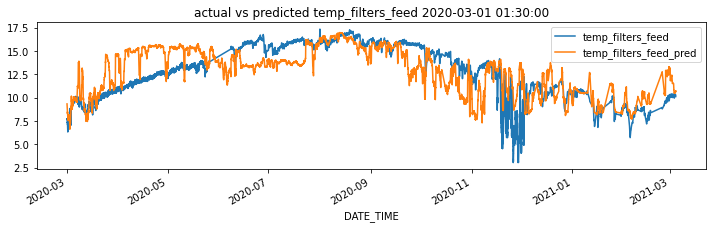

In [35]:
emg_eval.plot_actual_pred(ts.loc[cv_predictions.index][targets],cv_predictions)

In [36]:
model = SM.model


## sensitivity analysis

In [37]:
! pip install SALib

Looking in indexes: https://pypi.org/simple, https://:****@pkgs.dev.azure.com/innovyze/global/_packaging/app_emagin360/pypi/simple/
     |████████████████████████████████| 855 kB 6.4 MB/s eta 0:00:01
  Created wheel for SALib: filename=SALib-1.3.12-py2.py3-none-any.whl size=729049 sha256=70c5d1aed962f2afef22123f7ff50d262937387cc288d8d69f33fff5037be524
  Stored in directory: /home/ec2-user/.cache/pip/wheels/bf/9c/85/e568170c957265441b246799a8cd4c6d996ae7509dd42bafa8
Successfully built SALib


In [38]:
control_channel_features = filter_columns(ts[features], prefixes = ['do_bae'])


In [39]:
control_channel_features

['do_bae3_max_rr100',
 'do_bae2_max_rr60_lg-1',
 'do_bae4_max_rr100_lg-4',
 'do_bae2_min_rr100_lg-3',
 'do_bae3_max_rr100_lg-2',
 'do_bae2_mean_rr80_lg-1',
 'do_bae2_sum_rr90',
 'do_bae2_mean_rr100_lg-4',
 'do_bae2_sum_rr100_lg-4',
 'do_bae2_min_rr100_lg-2',
 'do_bae2_sum_rr80_lg-4',
 'do_bae2_mean_rr100',
 'do_bae2_sum_rr100',
 'do_bae2_mean_rr80_lg-3',
 'do_bae2_sum_rr100_lg-3',
 'do_bae2_mean_rr100_lg-1',
 'do_bae2_mean_rr90_lg-4',
 'do_bae2_mean_rr100_lg-2',
 'do_bae2_sum_rr100_lg-1']

In [40]:
import SALib.sample.morris
import SALib.analyze.morris


def gs_morris(problem,model1,test_df,cvs,feat_cols):
    ts = test_df.copy()
    X= SALib.sample.morris.sample(problem, 1000, num_levels=4)
    Y=np.zeros(X.shape[0])
    for i,x in enumerate(X):
        ts.loc[ts.index,cvs] =x
        pred = model1.predict(ts[feat_cols])
        Y[i] = pred.mean()
    Si = SALib.analyze.morris.analyze(problem, X, Y, conf_level=0.95, print_to_console=True, num_levels=4)

In [41]:
ts['do_bae4_max_rr100_lg-4'].describe()

count    32550.000000
mean         6.428690
std          2.475878
min          2.194000
25%          4.383000
50%          6.623000
75%          8.546000
max          9.937000
Name: do_bae4_max_rr100_lg-4, dtype: float64

In [42]:
problem = {
    'num_vars': 3,
    'names': ['do_bae2_mean_rr50','do_bae3_max_rr100_lg-4','do_bae4_max_rr100_lg-4'],
    'bounds': [[1.44, 3],[2, 8],[2,9]]
}

In [43]:
#use the model from the last iteration  of cross validation
gs_morris(problem,model,ts,problem['names'],features)


Parameter                         Mu_Star         Mu    Mu_Star_Conf      Sigma
do_bae2_mean_rr50                   0.000     -0.000           0.000      0.000
do_bae3_max_rr100_lg-4              0.000     -0.000           0.000      0.000
do_bae4_max_rr100_lg-4              0.020     -0.020           0.001      0.022


# HPO

In [82]:
import boto3
import sagemaker
import os

from io import StringIO



In [60]:
boto_sess = boto3.Session(region_name='us-east-1')
sage_client = boto3.Session(region_name='us-east-1').client('sagemaker')
sm_sess = sagemaker.Session(boto_session=boto_sess)

## Prepare train test data

In [ ]:
s3_bucket_name = 'innovyze-dev-ml-factory-artifacts-mle'


In [75]:
from emagin_forecast.component.utils import split_dataset, upload_data_frame_to_s3

train_data, test_data = split_dataset(ts)


In [90]:

# upload_data_frame_to_s3(train_data, s3_bucket_name, 'train')
# upload_data_frame_to_s3(test_data, s3_bucket_name, 'test')

train_data[features+targets].to_csv(f's3://{s3_bucket_name}/new_template/train.csv')
test_data[features+targets].to_csv(f's3://{s3_bucket_name}/new_template/test.csv')


## HPO training

In [48]:
from sagemaker.sklearn.estimator import SKLearn


In [102]:
settings = {
    "module_package": 'sklearn.ensemble',
    "module_name": 'RandomForestRegressor',
    "forecast_type": 'regression',
    "hyperparameters": "['max_depth', 'max_features', 'min_samples_leaf', 'min_samples_split', 'n-estimators']",
    "features": ' '.join(features),
    "target": ' '.join(targets),
    "split_method": 'ts_kfold_split'
}

In [50]:
hyperparameters = {
    "max_depth": 30,
    "max_features": "sqrt",
    "min_samples_leaf": 4,
    "min_samples_split": 2,
    "n-estimators": 50
}

In [53]:
metric_definitions = [{"Name": "mape_cv",
                       "Regex": "mape_cv=(.*?);"}]


In [94]:
output_path = 's3://innovyze-dev-ml-factory-artifacts-mle/'
datapath = 's3://innovyze-dev-ml-factory-artifacts-mle/new_template/'

In [106]:
job_name = 'SAUR-temp-filter'

In [114]:
rfr_estimator = SKLearn(
    base_job_name=job_name,
    entry_point='train_script.py',
    framework_version="0.20.0",
    hyperparameters={**settings, **hyperparameters},
    train_max_wait=86401,
    train_max_run=86400,
    metric_definitions=metric_definitions,
    output_path=output_path,
    role='arn:aws:iam::865412956762:role/SagemakerExecutionRole-dev',
    sagemaker_session=sm_sess,
    train_instance_count=1,
    train_instance_type="ml.m4.xlarge",
    train_use_spot_instances=True,
)


See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.


In [56]:
hyperparameter_ranges = {
    "n-estimators": sagemaker.tuner.IntegerParameter(20, 100),
    "max_depth": sagemaker.tuner.IntegerParameter(1, 20),
}

In [57]:
hpo_max_jobs = 10
hpo_max_parallel_jobs = 10

In [115]:
hpo_tuner = sagemaker.tuner.HyperparameterTuner(
    estimator=rfr_estimator,
    objective_metric_name=metric_definitions[0]["Name"],
    base_tuning_job_name=f"HPO-{job_name}",
    hyperparameter_ranges=hyperparameter_ranges,
    metric_definitions=metric_definitions,
    objective_type="Minimize",
    max_jobs=hpo_max_jobs,
    max_parallel_jobs=hpo_max_parallel_jobs,
)


In [116]:
hpo_tuner.fit(inputs={'train': datapath, 'test': datapath}, include_cls_metadata=False, wait=False)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: HPO-SAUR-temp-filter-210412-1951


## HPO tuning results

In [117]:
tuning_job_name = 'HPO-SAUR-temp-filter-210412-1951'

In [118]:
# run this cell to check current status of hyperparameter tuning job
tuning_job_result = sage_client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)

status = tuning_job_result['HyperParameterTuningJobStatus']
if status != 'Completed':
    print('Reminder: the tuning job has not been completed.')
    
job_count = tuning_job_result['TrainingJobStatusCounters']['Completed']
print("%d training jobs have completed" % job_count)



10 training jobs have completed


In [119]:
tuning_job_result

{'HyperParameterTuningJobName': 'HPO-SAUR-temp-filter-210412-1951',
 'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:865412956762:hyper-parameter-tuning-job/hpo-saur-temp-filter-210412-1951',
 'HyperParameterTuningJobConfig': {'Strategy': 'Bayesian',
  'HyperParameterTuningJobObjective': {'Type': 'Minimize',
   'MetricName': 'mape_cv'},
  'ResourceLimits': {'MaxNumberOfTrainingJobs': 10,
   'MaxParallelTrainingJobs': 10},
  'ParameterRanges': {'IntegerParameterRanges': [{'Name': 'n-estimators',
     'MinValue': '20',
     'MaxValue': '100',
     'ScalingType': 'Auto'},
    {'Name': 'max_depth',
     'MinValue': '1',
     'MaxValue': '20',
     'ScalingType': 'Auto'}],
   'ContinuousParameterRanges': [],
   'CategoricalParameterRanges': []},
  'TrainingJobEarlyStoppingType': 'Off'},
 'TrainingJobDefinition': {'StaticHyperParameters': {'_tuning_objective_metric': 'mape_cv',
   'features': '"temperature_dalmuir_max_rr80 temperature_dalmuir_max_rr90 temperature_dalmuir_max_rr90_

In [120]:
import pandas as pd


tuner = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name, sagemaker_session=sm_sess)

full_df = tuner.dataframe()


if len(full_df) > 0:
    hpo_df = full_df[full_df['FinalObjectiveValue'] > -float('inf')]
    if len(hpo_df) > 0:
        hpo_df = hpo_df.sort_values('FinalObjectiveValue')
        print("Number of training jobs with valid objective: %d" % len(hpo_df))
        print({"lowest":min(hpo_df['FinalObjectiveValue']),"highest": max(hpo_df['FinalObjectiveValue'])})
        pd.set_option('display.max_colwidth', -1)  # Don't truncate TrainingJobName        
    else:
        print("No training jobs have reported valid results yet.")
        
hpo_df

Number of training jobs with valid objective: 10
{'lowest': 14.232826232910156, 'highest': 16.333370208740234}


max_depth  n-estimators                                TrainingJobName  \
9  20.0       80.0          HPO-SAUR-temp-filter-210412-1951-001-93904d2a   
1  13.0       50.0          HPO-SAUR-temp-filter-210412-1951-009-caaf7a9f   
4  15.0       30.0          HPO-SAUR-temp-filter-210412-1951-006-130a9bc4   
7  3.0        82.0          HPO-SAUR-temp-filter-210412-1951-003-a052c3f6   
6  12.0       24.0          HPO-SAUR-temp-filter-210412-1951-004-4e12ca7e   
2  3.0        73.0          HPO-SAUR-temp-filter-210412-1951-008-48c91032   
5  12.0       32.0          HPO-SAUR-temp-filter-210412-1951-005-cab9a169   
8  10.0       22.0          HPO-SAUR-temp-filter-210412-1951-002-b818f5c5   
0  6.0        30.0          HPO-SAUR-temp-filter-210412-1951-010-7c095ace   
3  1.0        81.0          HPO-SAUR-temp-filter-210412-1951-007-28cd6706   

  TrainingJobStatus  FinalObjectiveValue         TrainingStartTime  \
9  Completed         14.232826           2021-04-12 19:53:58+00:00   
1  Completed         14.287197           2021-04-12 19:54:46+00:00   
4  Completed         14.521940           2021-04-12 19:54:14+00:00   
7  Completed         14.524205           2021-04-12 19:53:48+00:00   
6  Completed         14.566713           2021-04-12 19:54:04+00:00   
2  Completed         14.657952           2021-04-12 19:54:02+00:00   
5  Completed         14.787563           2021-04-12 19:53:46+00:00   
8  Completed         14.849351           2021-04-12 19:53:46+00:00   
0  Completed         15.098101           2021-04-12 19:53:59+00:00   
3  Completed         16.333370           2021-04-12 19:54:09+00:00   

            TrainingEndTime  TrainingElapsedTimeSeconds  
9 2021-04-12 19:56:58+00:00  180.0                       
1 2021-04-12 19:57:23+00:00  157.0                       
4 2021-04-12 19:56:44+00:00  150.0                       
7 2021-04-12 19:56:24+00:00  156.0                       
6 2021-04-12 19:56:34+00:00  150.0                       
2 2021-04-12 19:56:42+00:00  160.0                       
5 2021-04-12 19:56:10+00:00  144.0                       
8 2021-04-12 19:56:16+00:00  150.0                       
0 2021-04-12 19:56:26+00:00  147.0                       
3 2021-04-12 19:56:31+00:00  142.0